In [53]:
import nflreadpy as nfl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import pickle
from datetime import datetime





In [3]:
schedule = nfl.load_schedules([2021, 2022, 2023, 2024, 2025]).to_pandas() #Import schedules and game info for 2021-2025 seasons
games = schedule[
    (schedule['game_type']=='REG') & #include only regular season games
    (schedule['home_score'].notna())&
    (schedule['away_score'].notna())
].copy()

In [4]:
games['home_win'] = (games['home_score'] > games['away_score']).astype(int) #Home win variable
games

,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,...,away_qb_id,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium,home_win
0,2021_01_DAL_TB,2021,REG,1,2021-09-09,Thursday,20:20,DAL,29.0,TB,...,00-0033077,00-0019596,Dak Prescott,Tom Brady,Mike McCarthy,Bruce Arians,Shawn Hochuli,TAM00,Raymond James Stadium,1
1,2021_01_PHI_ATL,2021,REG,1,2021-09-12,Sunday,13:00,PHI,32.0,ATL,...,00-0036389,00-0026143,Jalen Hurts,Matt Ryan,Nick Sirianni,Arthur Smith,Scott Novak,ATL97,Mercedes-Benz Stadium,0
2,2021_01_PIT_BUF,2021,REG,1,2021-09-12,Sunday,13:00,PIT,23.0,BUF,...,00-0022924,00-0034857,Ben Roethlisberger,Josh Allen,Mike Tomlin,Sean McDermott,John Hussey,BUF00,New Era Field,0
3,2021_01_NYJ_CAR,2021,REG,1,2021-09-12,Sunday,13:00,NYJ,14.0,CAR,...,00-0037013,00-0034869,Zach Wilson,Sam Darnold,Robert Saleh,Matt Rhule,Clay Martin,CAR00,Bank of America Stadium,1
4,2021_01_MIN_CIN,2021,REG,1,2021-09-12,Sunday,13:00,MIN,24.0,CIN,...,00-0029604,00-0036442,Kirk Cousins,Joe Burrow,Mike Zimmer,Zac Taylor,Adrian Hill,CIN00,Paul Brown Stadium,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1390,2025_17_NE_NYJ,2025,REG,17,2025-12-28,Sunday,13:00,NE,42.0,NYJ,...,00-0039851,00-0028118,Drake Maye,Tyrod Taylor,Mike Vrabel,Aaron Glenn,Alex Kemp,NYC01,MetLife Stadium,0
1391,2025_17_NO_TEN,2025,REG,17,2025-12-28,Sunday,13:00,NO,34.0,TEN,...,00-0040743,00-0040676,Tyler Shough,Cam Ward,Kellen Moore,Brian Callahan,Adrian Hill,NAS00,Nissan Stadium,0
1392,2025_17_PHI_BUF,2025,REG,17,2025-12-28,Sunday,16:25,PHI,13.0,BUF,...,00-0036389,00-0034857,Jalen Hurts,Josh Allen,Nick Sirianni,Sean McDermott,Ron Torbert,BUF00,New Era Field,0
1393,2025_17_CHI_SF,2025,REG,17,2025-12-28,Sunday,20:20,CHI,38.0,SF,...,00-0039918,00-0037834,Caleb Williams,Brock Purdy,Ben Johnson,Kyle Shanahan,Alex Moore,SFO01,Levi's Stadium,1


In [5]:
# Load all available team level stats
team_stats = nfl.load_team_stats([2021, 2022, 2023, 2024, 2025]).to_pandas() #load team and game stats for 2021-2025 seasons
team_stats['turnovers_offense'] = (team_stats['passing_interceptions']+ #rows correspond to single game stats
                                 team_stats['sack_fumbles_lost']+
                                 team_stats['rushing_fumbles_lost']+
                                 team_stats['receiving_fumbles_lost']
                                 )
team_stats['turnovers_defense'] = (team_stats['def_interceptions']+
                                 team_stats['def_fumbles'])
team_stats['turnover_margin'] = (team_stats['turnovers_defense']-
                               team_stats['turnovers_offense'])
team_stats['completion_pct'] = (team_stats['completions']/team_stats['attempts'])


In [6]:
independent_variables = ['completions',
                       'passing_yards',
                       'passing_tds',
                       'rushing_yards',
                       'sacks_suffered',
                       'rushing_tds',
                       'completion_pct',
                       'turnovers_offense',
                       'turnovers_defense',
                       'turnover_margin',
                       'def_tackles_for_loss',
                       'penalty_yards',
                       'fg_pct',
                       'pat_pct',
                       ]


In [85]:
for var in independent_variables: #make an exponential weighted mean to favor more recent game stats
    team_stats[f'{var}_ewma'] = team_stats.groupby(['team', 'season'])[var].transform(
        lambda x: x.ewm(alpha=0.4, adjust=False).mean()
    )

#ewma_cols = [f'{col}_ewma' for col in ]

In [86]:
ewma_cols = [f'{col}_ewma' for col in independent_variables]
keep_cols = ['season', 'week', 'team', 'opponent_team'] + ewma_cols
df_filtered=team_stats[keep_cols]

df_filtered.to_csv('../data/df_clean.csv')

In [89]:
home_stats = df_filtered[['season', 'week', 'team'] + ewma_cols].copy()
home_stats.columns = ['season', 'week', 'home_team'] + [f'home_{col}' for col in ewma_cols]

# For away team stats
away_stats = df_filtered[['season', 'week', 'team'] + ewma_cols].copy()
away_stats.columns = ['season', 'week', 'away_team'] + [f'away_{col}' for col in ewma_cols]


In [118]:
games_with_stats=games.merge(
    home_stats,
    on=['season', 'week', 'home_team'],
    how='left'
).merge(
    away_stats,
    on=['season', 'week', 'away_team'],
    how='left'
)


games_with_stats = pd.read_csv('../data/games_with_stats1.csv')
games_with_stats


,game_id,season,game_type,week,gameday,away_team,away_score,home_team,home_score,home_win,...,away_sacks_suffered_ewma,away_rushing_tds_ewma,away_completion_pct_ewma,away_turnovers_offense_ewma,away_turnovers_defense_ewma,away_turnover_margin_ewma,away_def_tackles_for_loss_ewma,away_penalty_yards_ewma,away_fg_pct_ewma,away_pat_pct_ewma
0,2021_01_DAL_TB,2021,REG,1,2021-09-09,DAL,29.0,TB,31.0,1,...,1.000000,0.000000,0.724138,1.000000,2.000000,1.000000,0.000000,55.000000,0.600000,0.666667
1,2021_01_PHI_ATL,2021,REG,1,2021-09-12,PHI,32.0,ATL,6.0,0,...,1.000000,1.000000,0.771429,0.000000,0.000000,0.000000,6.000000,89.000000,1.000000,1.000000
2,2021_01_PIT_BUF,2021,REG,1,2021-09-12,PIT,23.0,BUF,16.0,0,...,2.000000,0.000000,0.562500,0.000000,0.000000,0.000000,5.000000,32.000000,1.000000,1.000000
3,2021_01_NYJ_CAR,2021,REG,1,2021-09-12,NYJ,14.0,CAR,19.0,1,...,6.000000,0.000000,0.540541,1.000000,0.000000,-1.000000,4.000000,30.000000,0.000000,0.000000
4,2021_01_MIN_CIN,2021,REG,1,2021-09-12,MIN,24.0,CIN,27.0,1,...,3.000000,1.000000,0.740000,1.000000,0.000000,-1.000000,7.000000,116.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1338,2025_17_NE_NYJ,2025,REG,17,2025-12-28,NE,42.0,NYJ,10.0,0,...,2.290953,1.336589,0.761168,0.734868,0.634728,-0.100140,4.489385,37.283919,0.568743,0.999791
1339,2025_17_NO_TEN,2025,REG,17,2025-12-28,NO,34.0,TEN,26.0,0,...,2.970224,0.806960,0.731817,0.961806,0.454473,-0.507333,6.740882,64.804603,0.757572,1.000000
1340,2025_17_PHI_BUF,2025,REG,17,2025-12-28,PHI,13.0,BUF,12.0,0,...,1.220025,0.803838,0.612742,0.496941,0.702044,0.205103,5.834745,46.880628,0.678306,0.948160
1341,2025_17_CHI_SF,2025,REG,17,2025-12-28,CHI,38.0,SF,42.0,1,...,0.717814,1.289252,0.573708,0.208395,1.065462,0.857067,3.142960,52.392077,0.920421,1.000000


In [156]:
df_clean = pd.read_csv('../data/df_clean.csv')
df_clean = df_clean.sort_values(by=['team', 'season'])
most_recent_stats=df_clean.groupby('team').last().reset_index()
most_recent_stats.to_csv("../data/most_recent_stats.csv")
most_recent_stats[keep_cols]

,season,week,team,opponent_team,completions_ewma,passing_yards_ewma,passing_tds_ewma,rushing_yards_ewma,sacks_suffered_ewma,rushing_tds_ewma,completion_pct_ewma,turnovers_offense_ewma,turnovers_defense_ewma,turnover_margin_ewma,def_tackles_for_loss_ewma,penalty_yards_ewma,fg_pct_ewma,pat_pct_ewma
0,2025,17,ARI,CIN,22.363123,233.890572,1.869158,73.868517,3.048872,0.074768,0.588119,0.663869,0.357385,-0.306484,3.382708,39.109969,0.610696,1.000000
1,2025,17,ATL,LA,18.289733,193.540539,1.463482,168.147086,0.721755,0.975521,0.627042,0.934703,1.815403,0.880701,5.511604,50.417706,0.817742,0.917053
2,2025,17,BAL,GB,15.074967,149.456993,0.821135,226.898219,1.720708,2.633127,0.729471,1.021268,1.029887,0.008618,2.837251,35.298677,0.874867,0.956676
3,2025,17,BUF,PHI,19.233818,212.983758,0.844160,150.280602,3.353408,2.074226,0.667836,0.764371,0.921025,0.156654,4.219813,38.939326,0.979622,0.486362
4,2025,17,CAR,SEA,16.734372,138.024304,1.045693,107.523397,1.917350,0.594272,0.628868,1.123716,1.389931,0.266214,4.333453,40.306151,0.951188,0.983220
5,2025,17,CHI,SF,20.999475,268.872799,1.929532,137.784191,0.717814,1.289252,0.573708,0.208395,1.065462,0.857067,3.142960,52.392077,0.920421,1.000000
6,2025,17,CIN,ARI,25.853994,296.397196,2.340490,107.954777,2.360753,1.787339,0.713579,0.622567,0.719863,0.097296,3.798919,30.578445,0.991323,0.920000
7,2025,17,CLE,PIT,18.137727,190.023660,1.021975,96.376878,2.760015,0.402565,0.652207,2.035649,0.397918,-1.637731,5.572521,41.934017,0.990278,0.999464
8,2025,17,DAL,WAS,22.346357,298.546903,1.653769,150.407145,3.487529,0.879572,0.610154,0.681813,0.178563,-0.503250,4.767754,67.631788,0.830849,0.999710
9,2025,17,DEN,KC,26.228896,253.704909,1.351378,112.905314,1.076668,1.117582,0.664144,1.136094,0.481472,-0.654622,4.139334,59.813861,0.874550,1.000000


In [120]:
feature_columns = []
for col in ewma_cols:
    diff_col = f'diff_{col}'
    games_with_stats[diff_col] = games_with_stats[f'home_{col}'] - games_with_stats[f'away_{col}']
    feature_columns.append(diff_col)
games_with_stats

,game_id,season,game_type,week,gameday,away_team,away_score,home_team,home_score,home_win,...,diff_sacks_suffered_ewma,diff_rushing_tds_ewma,diff_completion_pct_ewma,diff_turnovers_offense_ewma,diff_turnovers_defense_ewma,diff_turnover_margin_ewma,diff_def_tackles_for_loss_ewma,diff_penalty_yards_ewma,diff_fg_pct_ewma,diff_pat_pct_ewma
0,2021_01_DAL_TB,2021,REG,1,2021-09-09,DAL,29.0,TB,31.0,1,...,-1.000000,0.000000,-0.084138,3.000000,-1.000000,-4.000000,2.000000,51.000000,0.400000,0.333333
1,2021_01_PHI_ATL,2021,REG,1,2021-09-12,PHI,32.0,ATL,6.0,0,...,2.000000,-1.000000,-0.171429,0.000000,0.000000,0.000000,-1.000000,10.000000,0.000000,-1.000000
2,2021_01_PIT_BUF,2021,REG,1,2021-09-12,PIT,23.0,BUF,16.0,0,...,1.000000,0.000000,0.025735,1.000000,0.000000,-1.000000,-1.000000,49.000000,0.000000,0.000000
3,2021_01_NYJ_CAR,2021,REG,1,2021-09-12,NYJ,14.0,CAR,19.0,1,...,-5.000000,1.000000,0.145174,0.000000,1.000000,1.000000,2.000000,8.000000,1.000000,0.500000
4,2021_01_MIN_CIN,2021,REG,1,2021-09-12,MIN,24.0,CIN,27.0,1,...,2.000000,0.000000,0.000741,-1.000000,0.000000,1.000000,0.000000,-101.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1338,2025_17_NE_NYJ,2025,REG,17,2025-12-28,NE,42.0,NYJ,10.0,0,...,1.306121,-0.654529,-0.165519,0.941013,-0.634728,-1.575741,-0.198978,15.523772,0.413977,0.000209
1339,2025_17_NO_TEN,2025,REG,17,2025-12-28,NO,34.0,TEN,26.0,0,...,-0.350448,-0.210363,-0.126934,-0.377318,-0.334541,0.042777,-1.649221,-6.756948,0.162578,-0.001256
1340,2025_17_PHI_BUF,2025,REG,17,2025-12-28,PHI,13.0,BUF,12.0,0,...,2.133383,1.270388,0.055093,0.267430,0.218981,-0.048449,-1.614932,-7.941302,0.301316,-0.461798
1341,2025_17_CHI_SF,2025,REG,17,2025-12-28,CHI,38.0,SF,42.0,1,...,0.386320,0.393134,0.145480,0.800493,-0.645667,-1.446160,0.099816,-13.835875,-0.054659,-0.021877


In [ ]:
current_season = nfl.get_current_season()
current_week = nfl.get_current_week()

week_games = schedule[(schedule['week'] == current_week) & (schedule['season'] == current_season)]
week_games.game_id.to_list()

df_matchups = pd.merge(
    week_games,
    most_recent_stats[keep_cols],
    left_on='home_team',
    right_on='team',
    how='left'
).add_suffix('_home')

df_matchups = pd.merge(
    df_matchups,
    most_recent_stats[keep_cols],
    left_on='away_team_home',
    right_on='team',
    how='left',
    suffixes=("",'_away')
)
df_matchups

,game_id_home,season_x_home,game_type_home,week_x_home,gameday_home,weekday_home,gametime_home,away_team_home,away_score_home,home_team_home,...,sacks_suffered_ewma,rushing_tds_ewma,completion_pct_ewma,turnovers_offense_ewma,turnovers_defense_ewma,turnover_margin_ewma,def_tackles_for_loss_ewma,penalty_yards_ewma,fg_pct_ewma,pat_pct_ewma
0,2025_18_NO_ATL,2025,REG,18,2026-01-04,Sunday,13:00,NO,NaN,ATL,...,2.970224,0.806960,0.731817,0.961806,0.454473,-0.507333,6.740882,64.804603,0.757572,1.000000
1,2025_18_NYJ_BUF,2025,REG,18,2026-01-04,Sunday,16:25,NYJ,NaN,BUF,...,3.597075,0.682061,0.595649,1.675881,0.000000,-1.675881,4.290407,52.807692,0.982720,1.000000
2,2025_18_DET_CHI,2025,REG,18,2026-01-04,Sunday,16:25,DET,NaN,CHI,...,3.296378,0.645862,0.636884,2.467339,0.365062,-2.102277,4.391270,33.065813,0.924475,0.978538
3,2025_18_CLE_CIN,2025,REG,18,2026-01-04,Sunday,13:00,CLE,NaN,CIN,...,2.760015,0.402565,0.652207,2.035649,0.397918,-1.637731,5.572521,41.934017,0.990278,0.999464
4,2025_18_LAC_DEN,2025,REG,18,2026-01-04,Sunday,16:25,LAC,NaN,DEN,...,3.631724,1.021651,0.672623,0.833620,1.655184,0.821563,5.067541,35.792382,0.793655,0.800000
5,2025_18_IND_HOU,2025,REG,18,2026-01-04,Sunday,13:00,IND,NaN,HOU,...,1.777994,0.919849,0.601995,1.541543,0.756019,-0.785523,4.794516,41.358806,0.993550,0.963741
6,2025_18_TEN_JAX,2025,REG,18,2026-01-04,Sunday,13:00,TEN,NaN,JAX,...,2.619776,0.596596,0.604883,0.584488,0.119932,-0.464556,5.091660,58.047655,0.920150,0.998744
7,2025_18_ARI_LA,2025,REG,18,2026-01-04,Sunday,16:25,ARI,NaN,LA,...,3.048872,0.074768,0.588119,0.663869,0.357385,-0.306484,3.382708,39.109969,0.610696,1.000000
8,2025_18_KC_LV,2025,REG,18,2026-01-04,Sunday,16:25,KC,NaN,LV,...,2.657241,0.321389,0.579667,0.654469,0.856675,0.202205,4.124896,39.689868,0.882007,0.981532
9,2025_18_GB_MIN,2025,REG,18,2026-01-04,Sunday,13:00,GB,NaN,MIN,...,1.915119,1.143482,0.700514,1.453076,0.179013,-1.274064,2.615808,43.272894,0.972614,0.987384


In [ ]:
# 1. First merge for the Home Team
df_matchups = pd.merge(
    week_games,
    most_recent_stats[keep_cols],
    left_on='home_team',
    right_on='team',
    how='left'
)

# Rename the stat columns to indicate they belong to the Home team
# We skip the columns that were already in week_games
stats_to_rename = [col for col in keep_cols if col != 'team']
df_matchups = df_matchups.rename(columns={col: f"{col}_home" for col in stats_to_rename})

# 2. Second merge for the Away Team
df_matchups = pd.merge(
    df_matchups,
    most_recent_stats[keep_cols],
    left_on='away_team', # Use the original column name
    right_on='team',
    how='left',
    suffixes=("", "_away") 
)

# Rename the second set of stats
df_matchups = df_matchups.rename(columns={col: f"{col}_away" for col in stats_to_rename if col in df_matchups.columns})

df_matchups

In [101]:
train_data = games_with_stats[games_with_stats['season']< 2025]
test_data=games_with_stats[games_with_stats['season'] == 2025]



In [102]:
X_train = train_data[feature_columns]
y_train = train_data['home_win']

In [103]:
X_test = test_data[feature_columns]
y_test = test_data['home_win']

In [104]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [105]:
rf_model = RandomForestClassifier(n_estimators=200, random_state=67, max_depth=20, min_samples_split=20)
rf_model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",20
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",20
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(

In [106]:
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)
top_features = feature_importance.head(10)
feature_list = top_features['feature'].to_list()



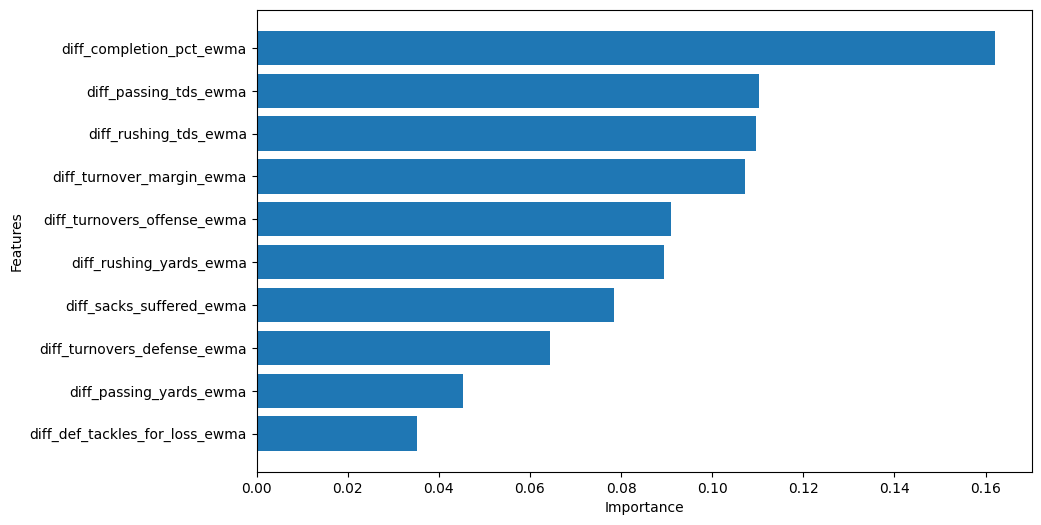

In [107]:
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.savefig('../outputs/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [108]:
X_train_selected = train_data[feature_list]
X_test_selected = test_data[feature_list]
X_train_selected


,diff_completion_pct_ewma,diff_passing_tds_ewma,diff_rushing_tds_ewma,diff_turnover_margin_ewma,diff_turnovers_offense_ewma,diff_rushing_yards_ewma,diff_sacks_suffered_ewma,diff_turnovers_defense_ewma,diff_passing_yards_ewma,diff_def_tackles_for_loss_ewma
0,-0.084138,1.000000,0.000000,-4.000000,3.000000,-8.000000,-1.000000,-1.000000,-24.000000,2.000000
1,-0.171429,-3.000000,-1.000000,0.000000,0.000000,-49.000000,2.000000,0.000000,-100.000000,-1.000000
2,0.025735,0.000000,0.000000,-1.000000,1.000000,42.000000,1.000000,0.000000,82.000000,-1.000000
3,0.145174,-1.000000,1.000000,1.000000,0.000000,66.000000,-5.000000,1.000000,21.000000,2.000000
4,0.000741,0.000000,0.000000,1.000000,-1.000000,82.000000,2.000000,0.000000,-101.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
1082,0.134684,1.867490,0.047508,-1.187197,0.590218,58.126229,-1.655363,-0.596979,64.851588,0.236618
1083,-0.087352,-0.951021,0.340253,-0.045845,-0.173317,-13.022920,-1.318406,-0.219161,24.904159,-0.895990
1084,-0.076917,-0.589153,-0.714392,-0.913019,0.517556,-41.571297,-0.132576,-0.395463,-53.835313,-0.050178
1085,-0.050923,1.507770,-0.700164,1.847150,-0.632479,-0.853213,-0.342250,1.214671,16.761985,2.254676


In [109]:
scaler_selected = StandardScaler()
X_train_scaled_selected = scaler.fit_transform(X_train_selected)
X_test_scaled_selected = scaler.transform(X_test_selected)


In [110]:
model = LogisticRegression(random_state=67, max_iter=1000)
model.fit(X_train_scaled, y_train)
lr_all_train = model.score(X_train_scaled, y_train)
lr_all_test = model.score(X_test_scaled, y_test)


In [111]:

#Logistic Regression - Selected Features
model_selected = LogisticRegression(random_state=41, max_iter=1000)
model_selected.fit(X_train_scaled_selected, y_train)
lr_sel_train = model_selected.score(X_train_scaled_selected, y_train)
lr_sel_test = model_selected.score(X_test_scaled_selected, y_test)

print("All variables train:", lr_all_train,
      "All variables test:", lr_all_test)
print("Selected variables train:", lr_sel_train,
      "Selected variables test:", lr_sel_test)


All variables train: 0.8150873965041399 All variables test: 0.8046875
Selected variables train: 0.8058877644894205 Selected variables test: 0.8203125


In [112]:
now=datetime.now()
formatted_string = now.strftime("%Y-%m-%d")
print(formatted_string)


2026-01-04


In [113]:
schedule

,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,...,wind,away_qb_id,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium
0,2021_01_DAL_TB,2021,REG,1,2021-09-09,Thursday,20:20,DAL,29.0,TB,...,9.0,00-0033077,00-0019596,Dak Prescott,Tom Brady,Mike McCarthy,Bruce Arians,Shawn Hochuli,TAM00,Raymond James Stadium
1,2021_01_PHI_ATL,2021,REG,1,2021-09-12,Sunday,13:00,PHI,32.0,ATL,...,NaN,00-0036389,00-0026143,Jalen Hurts,Matt Ryan,Nick Sirianni,Arthur Smith,Scott Novak,ATL97,Mercedes-Benz Stadium
2,2021_01_PIT_BUF,2021,REG,1,2021-09-12,Sunday,13:00,PIT,23.0,BUF,...,17.0,00-0022924,00-0034857,Ben Roethlisberger,Josh Allen,Mike Tomlin,Sean McDermott,John Hussey,BUF00,New Era Field
3,2021_01_NYJ_CAR,2021,REG,1,2021-09-12,Sunday,13:00,NYJ,14.0,CAR,...,0.0,00-0037013,00-0034869,Zach Wilson,Sam Darnold,Robert Saleh,Matt Rhule,Clay Martin,CAR00,Bank of America Stadium
4,2021_01_MIN_CIN,2021,REG,1,2021-09-12,Sunday,13:00,MIN,24.0,CIN,...,15.0,00-0029604,00-0036442,Kirk Cousins,Joe Burrow,Mike Zimmer,Zac Taylor,Adrian Hill,CIN00,Paul Brown Stadium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1406,2025_18_DAL_NYG,2025,REG,18,2026-01-04,Sunday,13:00,DAL,NaN,NYG,...,NaN,00-0033077,00-0040691,Dak Prescott,Jaxson Dart,Brian Schottenheimer,Brian Daboll,None,NYC01,MetLife Stadium
1407,2025_18_WAS_PHI,2025,REG,18,2026-01-04,Sunday,16:25,WAS,NaN,PHI,...,NaN,00-0026300,00-0036389,Josh Johnson,Jalen Hurts,Dan Quinn,Nick Sirianni,None,PHI00,Lincoln Financial Field
1408,2025_18_BAL_PIT,2025,REG,18,2026-01-04,Sunday,20:20,BAL,NaN,PIT,...,NaN,00-0034796,00-0023459,Lamar Jackson,Aaron Rodgers,John Harbaugh,Mike Tomlin,None,PIT00,Acrisure Stadium
1409,2025_18_SEA_SF,2025,REG,18,2026-01-03,Saturday,20:00,SEA,NaN,SF,...,NaN,00-0034869,00-0037834,Sam Darnold,Brock Purdy,Mike Macdonald,Kyle Shanahan,None,SFO01,Levi's Stadium


In [114]:
filename = '../models/finalized_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model_selected, file)

In [51]:
#Create a dataframe with rows corresponding to the ewma stats for each team. Use this to index
# individual teams to plug into model
df = pd.read_csv('../data/df_clean.csv')

team = input("Which game do you want to look at?")

team_df = df[(df['season'] == 2025) & (df['week'] == 17) & (df['team'] == team)]

if len(team_df) == 0:
    print(f"No data available for {team} in week 17, 2025")
else:
    opponent = team_df['opponent_team'].iloc[0]
    print(f"\nComparing {team} vs {opponent}")
    
opponent_df = df[(df['season'] == 2025) & (df['week'] == 17) & (df['team'] == opponent)]
if len(opponent_df) == 0:
    print(f"No data available for {opponent} in week 17")
else:
    numeric_cols = team_df.select_dtypes(include=['float']).columns.tolist()
    diff_data = {}
    diff_data['team'] = team
    diff_data['opponent'] = opponent
    diff_data['season'] = 2025
    diff_data['week'] = 17

    for col in numeric_cols:
        team_val = team_df[col].iloc[0]
        opp_val = opponent_df[col].iloc[0]
        diff = team_val-opp_val
        diff_data[f'diff_{col}'] = diff

diff_df = pd.DataFrame([diff_data])
diff_df


Comparing KC vs DEN


,team,opponent,season,week,diff_completions_ewma,diff_passing_yards_ewma,diff_passing_tds_ewma,diff_rushing_yards_ewma,diff_sacks_suffered_ewma,diff_rushing_tds_ewma,diff_completion_pct_ewma,diff_turnovers_offense_ewma,diff_turnovers_defense_ewma,diff_turnover_margin_ewma,diff_def_tackles_for_loss_ewma,diff_penalty_yards_ewma,diff_fg_pct_ewma,diff_pat_pct_ewma
0,KC,DEN,2025,17,-10.502215,-115.672103,-0.679726,-34.754644,1.580995,-0.796025,-0.084489,-0.480476,0.375576,0.856052,-0.013452,-20.128446,0.007567,-0.018097
